# **Classify reviews**

This code classify reviews into different classes
This is done following several steps

1- Read the file that contains the reviews that have been labelled manually. This is a csv file 

2- Read the file that containes the features that have been already extracted from these reviews (extracted using a pretrained LLM)

3- convert the 2 csv into data frames then arrays of : features (X) and labels (y)

4- Train a classifier onto those features and get the related metrics

# **How to use the code**
The code was run on google colab, each file used must be put in one's peronal google drive.

As of today, google colab can only access to the drive of the person that is running the code, hence by mounting google colab on the drive, only the current user's drive is visible to colab

Therefore, for executing the code, the folder named code_hexamind should be put directly in one's drive.

# **Prerequisites**

**Importing libraries**

In [ ]:
# install for multi label classification
!pip -q install scikit-multilearn # ! is for google colab, remove it if code run on local

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 KB 2.6 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from google.colab import drive
import matplotlib.pyplot as plt
import numpy as np

#Libraries for classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
#from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, multilabel_confusion_matrix, hamming_loss, classification_report, f1_score

from skmultilearn.problem_transform import ClassifierChain
from skmultilearn.problem_transform import LabelPowerset

from sklearn.linear_model import LogisticRegression

**Mounting the drive**

In [ ]:
# mounting the drive
drive.mount('/content/drive')

Mounted at /content/drive


**Defining the names**

In [ ]:
# specifying the working directory
main_Folder="/content/drive/My Drive/Review_analysis/"
data_Folder = main_Folder+'data/'
# folder of training
csv_data=data_Folder+'data.csv' 
csv_labels=data_Folder+'20230220_selected_df.csv' 
#csv_indices = data_Folder+ 'with_embed.csv'

# **Reading the csv**
- First the data, i.e. the feature embeding for each review

In [ ]:
df_data = pd.read_csv (csv_data, header=None, sep=",")
print(df_data.shape)

(649, 768)


In [ ]:
# uncomment if you want to see 
#df_data

- Then the labels

In [ ]:
df_label = pd.read_csv (csv_labels)
df_label.shape

(276, 34)

In [ ]:
# uncomment if you want to see 
#df_label

- Then the indices

In [ ]:
indices= df_label.iloc[:,0]
indices.shape

(276,)

In [ ]:
# uncomment if you want to see 
#indices

Now, we need to have the feature vectors from df_data that concern the labels in df_labels. This information is contained in indices computed previously

In [ ]:
df_data  = df_data.iloc[indices,:]

In [ ]:
df_labels= df_label.iloc[:,-4:]

In [ ]:
print("size of the data ", df_data.shape, "size of the labels ", df_labels.shape)

size of the data  (276, 768) size of the labels  (276, 4)


# **Preparing the data for training the head**

In [ ]:
X= df_data.to_numpy()
y= df_labels.to_numpy()

In [ ]:
X_train_all, X_valid, y_train_all, y_valid = train_test_split( X, y, test_size=0.33, random_state=42)

In [ ]:
y_valid.shape

(92, 4)

After splitting the data set, divide it into 4 labels so that we have a classification of each class independently

In [ ]:
# Buying experience
y_train_BE = y_train_all[:,0]
y_valid_BE= y_valid[:,0]
# Product
y_train_PD = y_train_all[:,1]
y_valid_PD= y_valid[:,1]
# Delivery mode
y_train_DM = y_train_all[:,2]
y_valid_DM= y_valid[:,2]
# After Sale
y_train_AS = y_train_all[:,3]
y_valid_AS = y_valid[:,3]

In [ ]:
print("data train size : ", X_train_all.shape, "label train size : ", y_train_BE.shape, 
      "data test size : ", X_valid.shape, "label test size : ", y_valid_BE.shape, )

data train size :  (184, 768) label train size :  (184,) data test size :  (92, 768) label test size :  (92,)


# **Training a logistic regressor based classifier for multilabel classification**
We will be using the multi label classification of Sickit learn.
Note that it is most often used with an SVM classifier but can be used with a deep network.
In this pipeline we use SVM with three methods and report the results.
For more inofrmation, one can refer to :
http://scikit.ml/

**First, classify using a logistic regression for each class**

In [ ]:
def train_and_report(X_train, y_train, X_valid, y_valid):
  lr_clf = LogisticRegression(max_iter=3000)
  lr_clf.fit(X_train, y_train)
  y_pred = lr_clf.predict(X_valid)
  accuracy = accuracy_score(y_valid, y_pred, normalize=False)
  F1 = f1_score(y_valid, y_pred, average='macro')
  return [accuracy, F1]

In [ ]:
def plot_metrics(size_training, F1, Accuracy):
  text= ['Size of the training set is: '+str(size_training)]

  plt.figure(figsize=(18, 3))

  plt.subplot(121)
  plt.plot(size_training, F1)
  plt.scatter(size_training, F1)
  plt.xlabel('Size of the training')
  plt.ylabel('F1 Score')

  plt.subplot(122)
  plt.plot(size_training, Accuracy)
  plt.scatter(size_training, Accuracy)
  plt.xlabel('Size of the training')
  plt.ylabel('Accuracy')

  plt.suptitle('Plotting of the metrics according to the size of the training set')
  plt.show()

  print(text)

### **For the class Buying experience**

In [ ]:
from sklearn.dummy import DummyClassifier
# Vary the training size and train

import time

start_time = time.time()

Accuracy_BE=[]
F1_BE=[]
size_training=[]

Accuracy_Dummy=[]
F1_Dummy=[]

for vary_size in range(10, 100, 1):
  X_train, X_valid_useless, y_train, y_valid_useless = train_test_split( X_train_all, y_train_BE, test_size=1-vary_size/100, random_state=43)
  [Acc, F1 ] = train_and_report(X_train, y_train, X_valid, y_valid_BE)
  # print the result
  Accuracy_BE.append(Acc)
  F1_BE.append(F1)
  size_training.append(X_train.shape[0])

  dummy_clf = DummyClassifier()
  dummy_clf.fit(X_train, y_train)
  y_pred = dummy_clf.predict(X_valid)
  Acc_Dummy = accuracy_score(y_valid_BE, y_pred, normalize=False)
  F1_dum = f1_score(y_valid_BE, y_pred, average='macro')
  Accuracy_Dummy.append(Acc_Dummy)
  F1_Dummy.append(F1_dum)

#print(time.time() - start_time, "seconds")
print(round(time.time() - start_time), "seconds")

5 seconds


### **Plot the impact of varying the size of the training set**

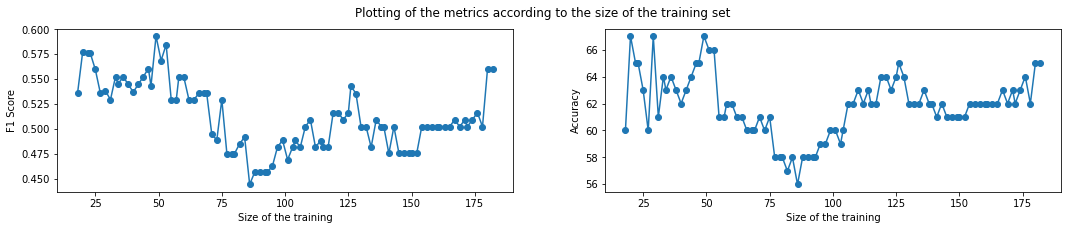

['Size of the training set is: [18, 20, 22, 23, 25, 27, 29, 31, 33, 34, 36, 38, 40, 42, 44, 46, 47, 49, 51, 53, 55, 57, 58, 60, 62, 64, 66, 68, 69, 71, 73, 75, 77, 79, 80, 82, 84, 86, 88, 90, 92, 93, 95, 97, 99, 101, 103, 104, 106, 108, 110, 112, 114, 115, 117, 119, 121, 123, 125, 126, 128, 130, 132, 134, 136, 138, 139, 141, 143, 145, 147, 149, 150, 152, 154, 156, 158, 160, 161, 163, 165, 167, 169, 171, 172, 174, 176, 178, 180, 182]']


In [ ]:
plot_metrics(size_training, F1_BE, Accuracy_BE)

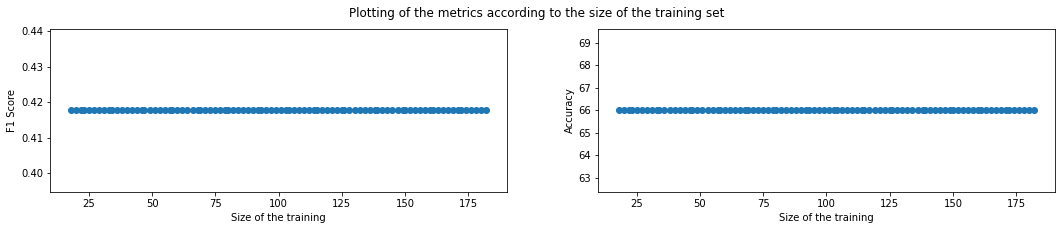

['Size of the training set is: [18, 20, 22, 23, 25, 27, 29, 31, 33, 34, 36, 38, 40, 42, 44, 46, 47, 49, 51, 53, 55, 57, 58, 60, 62, 64, 66, 68, 69, 71, 73, 75, 77, 79, 80, 82, 84, 86, 88, 90, 92, 93, 95, 97, 99, 101, 103, 104, 106, 108, 110, 112, 114, 115, 117, 119, 121, 123, 125, 126, 128, 130, 132, 134, 136, 138, 139, 141, 143, 145, 147, 149, 150, 152, 154, 156, 158, 160, 161, 163, 165, 167, 169, 171, 172, 174, 176, 178, 180, 182]']


In [ ]:
plot_metrics(size_training, F1_Dummy, Accuracy_Dummy)

### **For the class Product**

In [ ]:
from sklearn.dummy import DummyClassifier
# Vary the training size and train
Accuracy_PD=[]
F1_PD=[]
size_training=[]

Accuracy_Dummy=[]
F1_Dummy=[]

for vary_size in range(10, 100, 1):
  X_train, X_valid_useless, y_train, y_valid_useless = train_test_split( X_train_all, y_train_PD, test_size=1-vary_size/100, random_state=43)
  [Acc, F1 ] = train_and_report(X_train, y_train, X_valid, y_valid_PD)
  # print the result
  Accuracy_PD.append(Acc)
  F1_PD.append(F1)
  size_training.append(X_train.shape[0])

  dummy_clf = DummyClassifier()
  dummy_clf.fit(X_train, y_train)
  y_pred = dummy_clf.predict(X_valid)
  Acc_Dummy = accuracy_score(y_valid_PD, y_pred, normalize=False)
  F1_dum = f1_score(y_valid_PD, y_pred, average='macro')
  Accuracy_Dummy.append(Acc_Dummy)
  F1_Dummy.append(F1_dum)

### **Plot the impact of varying the size of the training set**

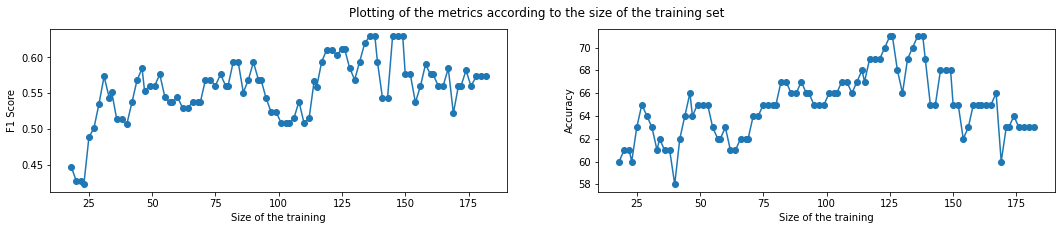

['Size of the training set is: [18, 20, 22, 23, 25, 27, 29, 31, 33, 34, 36, 38, 40, 42, 44, 46, 47, 49, 51, 53, 55, 57, 58, 60, 62, 64, 66, 68, 69, 71, 73, 75, 77, 79, 80, 82, 84, 86, 88, 90, 92, 93, 95, 97, 99, 101, 103, 104, 106, 108, 110, 112, 114, 115, 117, 119, 121, 123, 125, 126, 128, 130, 132, 134, 136, 138, 139, 141, 143, 145, 147, 149, 150, 152, 154, 156, 158, 160, 161, 163, 165, 167, 169, 171, 172, 174, 176, 178, 180, 182]']


In [ ]:
plot_metrics(size_training, F1_PD, Accuracy_PD)

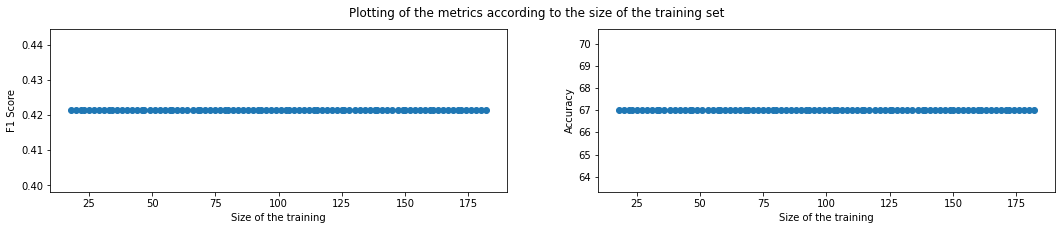

['Size of the training set is: [18, 20, 22, 23, 25, 27, 29, 31, 33, 34, 36, 38, 40, 42, 44, 46, 47, 49, 51, 53, 55, 57, 58, 60, 62, 64, 66, 68, 69, 71, 73, 75, 77, 79, 80, 82, 84, 86, 88, 90, 92, 93, 95, 97, 99, 101, 103, 104, 106, 108, 110, 112, 114, 115, 117, 119, 121, 123, 125, 126, 128, 130, 132, 134, 136, 138, 139, 141, 143, 145, 147, 149, 150, 152, 154, 156, 158, 160, 161, 163, 165, 167, 169, 171, 172, 174, 176, 178, 180, 182]']


In [ ]:
plot_metrics(size_training, F1_Dummy, Accuracy_Dummy)

### **For the class DM**

In [ ]:
from sklearn.dummy import DummyClassifier
# Vary the training size and train
Accuracy_DM=[]
F1_DM=[]
size_training=[]

Accuracy_Dummy=[]
F1_Dummy=[]

for vary_size in range(10, 100, 1):
  X_train, X_valid_useless, y_train, y_valid_useless = train_test_split( X_train_all, y_train_DM, test_size=1-vary_size/100, random_state=43)
  [Acc, F1 ] = train_and_report(X_train, y_train, X_valid, y_valid_DM)
  # print the result
  Accuracy_DM.append(Acc)
  F1_DM.append(F1)
  size_training.append(X_train.shape[0])

  dummy_clf = DummyClassifier()
  dummy_clf.fit(X_train, y_train)
  y_pred = dummy_clf.predict(X_valid)
  Acc_Dummy = accuracy_score(y_valid_DM, y_pred, normalize=False)
  F1_dum = f1_score(y_valid_DM, y_pred, average='macro')
  Accuracy_Dummy.append(Acc_Dummy)
  F1_Dummy.append(F1_dum)

### **Plot the impact of varying the size of the training set**

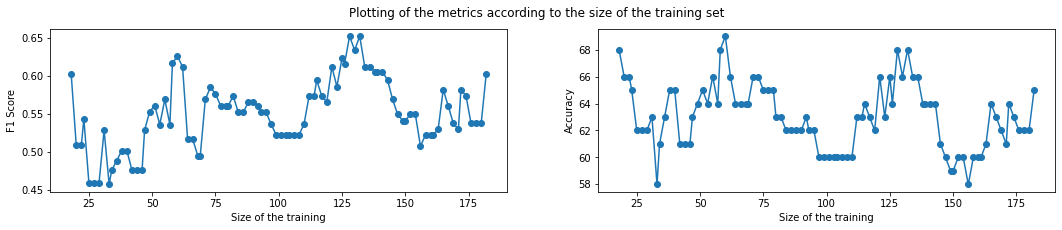

['Size of the training set is: [18, 20, 22, 23, 25, 27, 29, 31, 33, 34, 36, 38, 40, 42, 44, 46, 47, 49, 51, 53, 55, 57, 58, 60, 62, 64, 66, 68, 69, 71, 73, 75, 77, 79, 80, 82, 84, 86, 88, 90, 92, 93, 95, 97, 99, 101, 103, 104, 106, 108, 110, 112, 114, 115, 117, 119, 121, 123, 125, 126, 128, 130, 132, 134, 136, 138, 139, 141, 143, 145, 147, 149, 150, 152, 154, 156, 158, 160, 161, 163, 165, 167, 169, 171, 172, 174, 176, 178, 180, 182]']


In [ ]:
plot_metrics(size_training, F1_DM, Accuracy_DM)

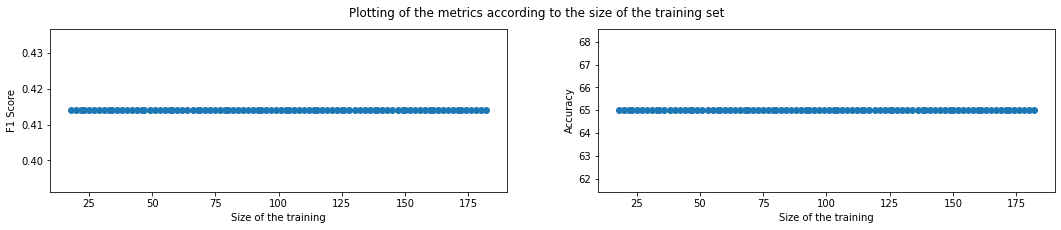

['Size of the training set is: [18, 20, 22, 23, 25, 27, 29, 31, 33, 34, 36, 38, 40, 42, 44, 46, 47, 49, 51, 53, 55, 57, 58, 60, 62, 64, 66, 68, 69, 71, 73, 75, 77, 79, 80, 82, 84, 86, 88, 90, 92, 93, 95, 97, 99, 101, 103, 104, 106, 108, 110, 112, 114, 115, 117, 119, 121, 123, 125, 126, 128, 130, 132, 134, 136, 138, 139, 141, 143, 145, 147, 149, 150, 152, 154, 156, 158, 160, 161, 163, 165, 167, 169, 171, 172, 174, 176, 178, 180, 182]']


In [ ]:
plot_metrics(size_training, F1_Dummy, Accuracy_Dummy)

### **For the class AS**

In [ ]:
from sklearn.dummy import DummyClassifier
# Vary the training size and train
Accuracy_AS=[]
F1_AS=[]
size_training=[]

Accuracy_Dummy=[]
F1_Dummy=[]

for vary_size in range(10, 100, 1):
  X_train, X_valid_useless, y_train, y_valid_useless = train_test_split( X_train_all, y_train_AS, test_size=1-vary_size/100, random_state=43)
  [Acc, F1 ] = train_and_report(X_train, y_train, X_valid, y_valid_AS)
  # print the result
  Accuracy_AS.append(Acc)
  F1_AS.append(F1)
  size_training.append(X_train.shape[0])

  dummy_clf = DummyClassifier()
  dummy_clf.fit(X_train, y_train)
  y_pred = dummy_clf.predict(X_valid)
  Acc_Dummy = accuracy_score(y_valid_AS, y_pred, normalize=False)
  F1_dum = f1_score(y_valid_AS, y_pred, average='macro')
  Accuracy_Dummy.append(Acc_Dummy)
  F1_Dummy.append(F1_dum)

### **Plot the impact of varying the size of the training set**

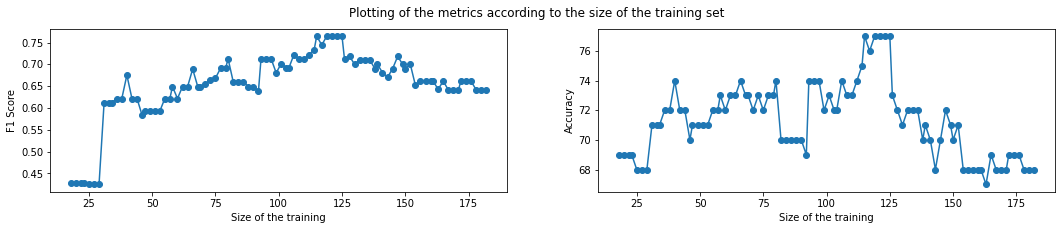

['Size of the training set is: [18, 20, 22, 23, 25, 27, 29, 31, 33, 34, 36, 38, 40, 42, 44, 46, 47, 49, 51, 53, 55, 57, 58, 60, 62, 64, 66, 68, 69, 71, 73, 75, 77, 79, 80, 82, 84, 86, 88, 90, 92, 93, 95, 97, 99, 101, 103, 104, 106, 108, 110, 112, 114, 115, 117, 119, 121, 123, 125, 126, 128, 130, 132, 134, 136, 138, 139, 141, 143, 145, 147, 149, 150, 152, 154, 156, 158, 160, 161, 163, 165, 167, 169, 171, 172, 174, 176, 178, 180, 182]']


In [ ]:
plot_metrics(size_training, F1_AS, Accuracy_AS)

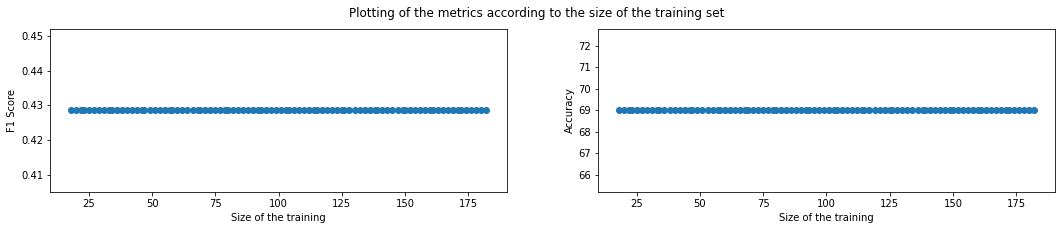

['Size of the training set is: [18, 20, 22, 23, 25, 27, 29, 31, 33, 34, 36, 38, 40, 42, 44, 46, 47, 49, 51, 53, 55, 57, 58, 60, 62, 64, 66, 68, 69, 71, 73, 75, 77, 79, 80, 82, 84, 86, 88, 90, 92, 93, 95, 97, 99, 101, 103, 104, 106, 108, 110, 112, 114, 115, 117, 119, 121, 123, 125, 126, 128, 130, 132, 134, 136, 138, 139, 141, 143, 145, 147, 149, 150, 152, 154, 156, 158, 160, 161, 163, 165, 167, 169, 171, 172, 174, 176, 178, 180, 182]']


In [ ]:
plot_metrics(size_training, F1_Dummy, Accuracy_Dummy)

# Trying other classifiers

In [ ]:
from sklearn import svm
X_train, X_valid, y_train, y_valid = train_test_split( X, y[:,3], test_size=0.33, random_state=43)
clf = svm.SVC()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_valid)
accuracy = accuracy_score(y_valid, y_pred, normalize=False)
F1 = f1_score(y_valid, y_pred, average='macro')
print(accuracy,F1)

62 0.4025974025974026


In [ ]:
from sklearn.linear_model import SGDClassifier
X_train, X_valid, y_train, y_valid = train_test_split( X, y[:,3], test_size=0.33, random_state=43)
clf = SGDClassifier(loss="hinge", penalty="l2", max_iter=5)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_valid)
accuracy = accuracy_score(y_valid, y_pred, normalize=False)
F1 = f1_score(y_valid, y_pred, average='macro')
print(accuracy,F1)

61 0.42765402368051375


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


In [ ]:
from sklearn.neighbors import NearestCentroid
X_train, X_valid, y_train, y_valid = train_test_split( X, y[:,3], test_size=0.33, random_state=43)
clf = NearestCentroid()
y_pred ==clf.fit(X_train, y_train)
accuracy = accuracy_score(y_valid, y_pred, normalize=False)
F1 = f1_score(y_valid, y_pred, average='macro')
print(accuracy,F1)

61 0.42765402368051375
